# How to build time series models
In this post, I will demonstrate how to load time series data, normalize the data, and build a model to predict future values of the time series. For this example, I'm going to use historical Apple stock data. You can get the data yourself by getting a Quandl API key. See this [post](https://johnkmaxi.github.io/blog/2018/04/22/Bollinger-Band-Trading-with-Apple-Stock) for a the nuts and bolts of the quandl_stocks function. The first thing we'll do is grab the data.

The purpose of this post is to show a quick example of getting and formatting the data. We're going to use a really simple linear regression model, which as you will see, actually does a really terrible job on this particular problem. However, we can use the foundation we build here with other types of models or feature engineering to improve the performance of the model.

# Import data

In [1]:
import quandlkey as qk
data = qk.quandl_stocks('AAPL') # data from 2000/1/1 to today
data.head()

,WIKI/AAPL - Open,WIKI/AAPL - High,WIKI/AAPL - Low,WIKI/AAPL - Close,WIKI/AAPL - Volume,WIKI/AAPL - Ex-Dividend,WIKI/AAPL - Split Ratio,WIKI/AAPL - Adj. Open,WIKI/AAPL - Adj. High,WIKI/AAPL - Adj. Low,WIKI/AAPL - Adj. Close,WIKI/AAPL - Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


There are several columns of data available to work with and using some combination of them is likely to produce the best results. For this demonstration, we're going to use just one column, the Adjusted Close.

In [2]:
# Only need to work with the adj. close
close = data['WIKI/AAPL - Adj. Close']

The problem we are trying to solve in this demonstration is to predict the stock price on a given day by using the price from the previous two days. To make this problem more conducive for use with a machine learning model we need to do some data normalizing. When working with financial data, it is standard practice to convert the actual price into daily percent returns (DR). We do this by dividing the stock price on day $x_t$ by the price from the day before, $x_{t-1}$:

$$ DR = \frac{x_t}{x_{t-1}}$$

# Convert Adj. Close to % Change from Previous Day

In [3]:
# convert the price to a % change from the previous day
close = (close/close.shift(1))-1

# Create a time lag DataFrame

In this example, we will use the previous 2 days daily return to predict the predict the daily return for the next day. The primary reason for making the model this way is to allow for easy visualization.

Pandas has a built in `shift()` method for just this purpose. `shift` takes an integer as an argument indicating how many positions to shift the data by. Negative values shift the data in the reverse direction. See the [docs](http://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.shift.html) for other arguments `shift` can take.

In [4]:
# use close to shift(1)
close = pd.concat([close,close.shift(1),close.shift(2)],axis=1)
# rename the columns
close.columns = ['Y','X1','X2']
# get rid of NaN values after using shift
close.dropna(inplace=True)
close.head()

,Y,X1,X2
Date,,,
2000-01-06,-0.086538,0.014634,-0.084331
2000-01-07,0.047368,-0.086538,0.014634
2000-01-10,-0.017588,0.047368,-0.086538
2000-01-11,-0.051151,-0.017588,0.047368
2000-01-12,-0.059946,-0.051151,-0.017588


# Visualize the data

Let's take a look at the values we are trying to predict. Visualizing the data is an important step in the modeling processing, esspecially during exploratory data analysis. Visualizing the data helps in developing an intuition of the data. To start, we'll plot the target values as a line plot and the two features as a scatter plot. We'll color each dot in the feature based on whether the daily return is positive (green) or negative (red) to see if there is any visual separation of the features with respect to the direction of the daily return.

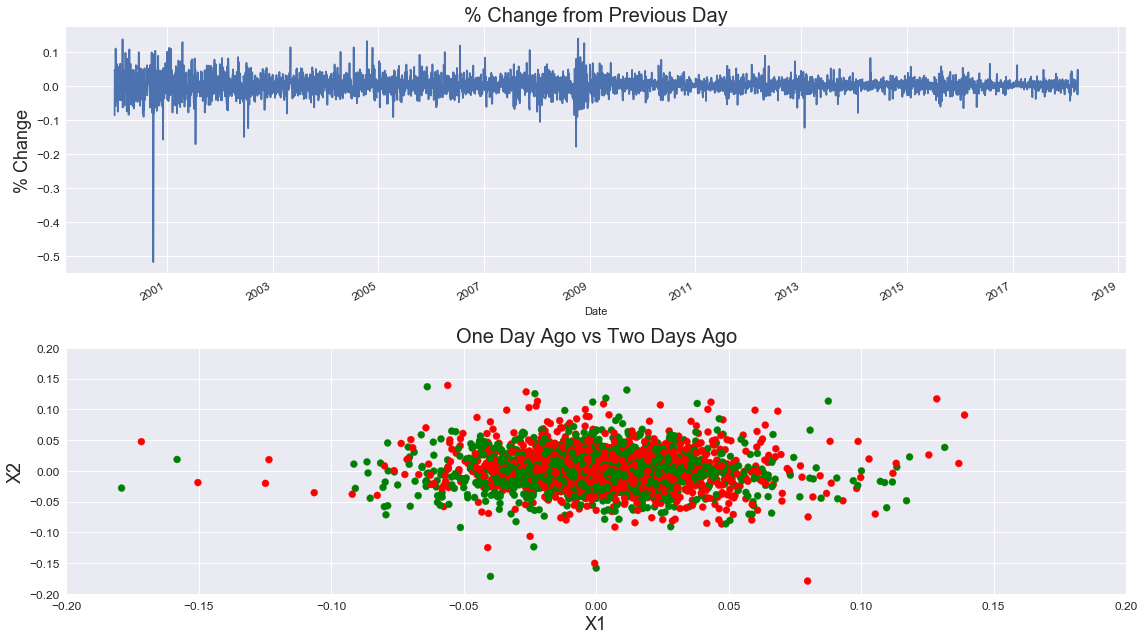

In [22]:
%matplotlib inline
fig, ax = plt.subplots(2, figsize=(16,9))
close['Y'].plot(kind='line', ax=ax[0])
ax[1].scatter(close['X1'],close['X2'],c=['r' if x<0 else 'g' for x in close['Y']])
ax[1].set_xlim(-0.2,0.2) # set the plot limits to zoom in on the bulk of the data
ax[1].set_ylim(-0.2,0.2)
ax[0].set_title('% Change from Previous Day', fontsize=20)
ax[0].set_ylabel('% Change', fontsize=18)
ax[1].set_title('One Day Ago vs Two Days Ago', fontsize=20)
ax[1].set_xlabel('X1', fontsize=18)
ax[1].set_ylabel('X2', fontsize=18)
for a in ax:
    for tick in a.get_xticklabels():
        tick.set_fontsize(12)
    for tick in a.get_yticklabels():
        tick.set_fontsize(12)
fig.tight_layout();

Our visualizations show that there is a lot of fluctuation in the day to day return of the stock. On this scale no apparaent pattern or trends are clearly evident. We should also notice that there is no separation of days when the price went up or down using our two input features. This is a big red flag indicating that that we aren't likely to have good model performance, especially with a linear-type model we are using here. We would want to pick a model that has more parameters or can learn non-linear features (such as an artifical neural network or a decision tree/random forest).

For now, let's move on to using our data to train a model. It's important in time series modeling to not include future events in the training data. if we do, we are essentially looking into the future during training, resulting in inflated model performance. For this reason, the train/test split is usually done by including all values up to a certain point in the training set, and all remaining values in the test set.

# Split into train and test set

In [23]:
# we'll use the first 60% of the data as a training set
split_index = int(len(close)*0.6)
train = close.iloc[:split_index,:]
test = close.iloc[split_index:,:]
ytrain = train['Y']
Xtrain = train.drop('Y', axis=1)
ytest = test['Y']
Xtest = test.drop('Y', axis=1)

# Train the model

For simplicity, we'll use a linear regression model. After training, we'll have a set of weights and a bias that we can use to calculate new daily returns with the formula

$$ DR = w_1x_1 + w_2x_2 + b$$

where $w_1$ and $w_2$ are the coefficients by which we multiply the $DR$ from one and two days ago. $b$ is the bias term which sets the x-intercept for the equation.

Sklearn is usually my go to for model development, keep in mind that numpy and scipy both have methods for fitting linear regressions. When speed counts, those libraries tend to be a little faster. The code below imports the LinearRegression class, instantiates it, fits the model to the data, and then prints out $w_1$, $w_2$, and $b$.

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(Xtrain, ytrain)
print(lr.coef_, lr.intercept_)

[-0.04024398 -0.016456  ] 0.00150257519941


# Score the model

Now we need to find out if our model is any good. To do that we score the model against the test data. The mean squared error is a commonly used metric for regression problems. It is computed by taking the average over all points of the squared difference between each corresponding target value and prediction:

$$MSE = \frac{1}{n}\Sigma(\hat{y} - y)$$

where $\hat{y}$ is the predicted value and $y$ is the know target.

Sklearn uses the $R^2$ value as the built in way to evaluate regression models. It typically ranges from 0 to 1, although negative scores are possible. The $R^2$ value represents how well the model matches the predictions compared to a model that only predicts the mean of all the values. Therefore, a score of 1 indicates perfect predictions, a score of 0 indicates the model is no better than simply predicting the mean of all the target points, and negative values indicate the model performs worse than a mean model. One caveat of the $R^2$ is that it will increase as more predictors are added to the model. If using $R^2$ as the sole scoring metric be sure to take this into account by using the adjusted $R^2$ in conjuction with Mallow's Cp to account for the number of factors in the model.

In [18]:
from sklearn.metrics import mean_squared_error
# the R^2 value, 1.0 = perfect predictions, 0 = constant value, < 0 = worse than constant prediction
print('R^2: ', lr.score(Xtest, ytest))
# MSE
print('MSE: ', mean_squared_error(ytest,lr.predict(Xtest)))

R^2:  0.0338849274109
MSE:  0.00340881353349


In [19]:
# Baseline regressors
base_predictor = [np.mean(ytrain) for x in ytest]
print('R^2: ', r2_score(ytest, base_predictor))
print('MSE: ', mean_squared_error(ytest, base_predictor))

R^2:  -0.0172624440997
MSE:  0.00358928049561


The R^2 value indicates that the model actually does worse than simply predicting the mean of y for every prediction. A negative R^2 value can also arise when when the model is not fitted on the data being tested, as is the case here. A linear model is clearly not a good choice for modeling the data used here.

# Plot the Predictions

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,9))
ytest.plot(kind='line',ax=ax)
ax.plot(Xtest.index, lr.predict(Xtest.values));

# Features vs Target, Target Distribution

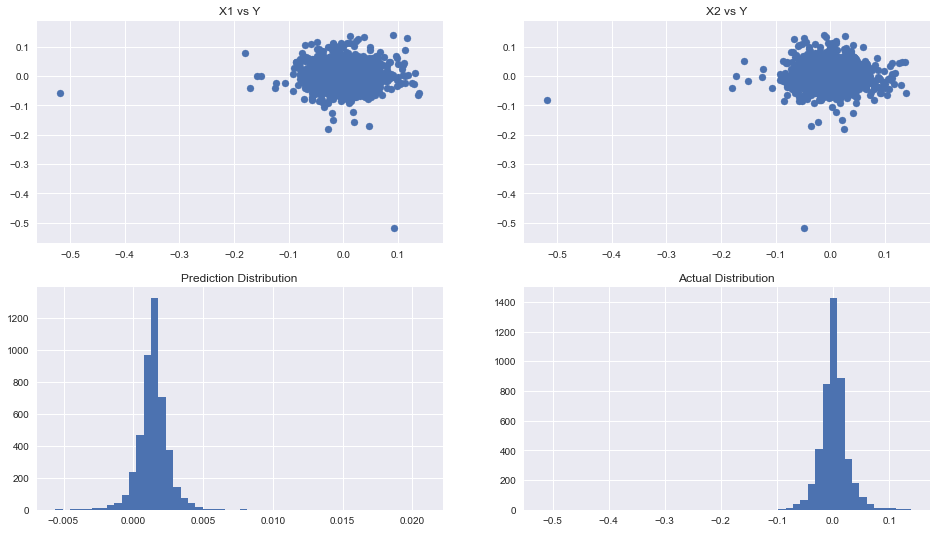

In [11]:
fig, ax = plt.subplots(2,2,figsize=(16,9))
ax[0][0].scatter(close['X1'],close['Y'])
ax[0][0].set_title('X1 vs Y')
ax[0][1].scatter(close['X2'],close['Y'])
ax[0][1].set_title('X2 vs Y')
ax[1][0].hist(lr.predict(close.loc[:,['X1','X2']]),50);
ax[1][0].set_title('Prediction Distribution')
ax[1][1].hist(close['Y'],50);
ax[1][1].set_title('Actual Distribution');